# Proposta Técnica: Inteligência de Sinais em Séries Temporais Financeiras

---

## Visão Geral - Executive Summary**

Este projeto propõe o desenvolvimento de uma pipeline de Machine Learning end-to-end para a extração de tendências estruturais em ativos do S&P 500. A abordagem diferencia-se ao tratar o preço não como uma variável isolada, mas como um sinal composto por uma componente de tendência (drift) e uma componente de ruído (estocástica/sentimento).

## Arquitetura da Solução e Workflow de MLOpsFase**

**Fase I - Ingestão e Processamento de Sinais (Data Engineering)**
    
Data Ingestion: Consumo de dados OHLCV via APIs financeiras (ex: Yahoo Finance, Alpha Vantage).

Signal Decomposition: Aplicação de filtros avançados (Kalman, Wavelets ou HP Filter) para decompor o preço em:
- $S_{t}$ (Signal): A tendência estrutural latente.
- $\epsilon_{t}$ (Noise): O resíduo, tratado como uma série temporal independente que reflete a volatilidade e o sentimento de curto prazo.
- **Feature Engineering** - Extração de indicadores técnicos clássicos. Cálculo de níveis dinâmicos de suporte e resistência via algoritmos de clustering. Engenharia de atributos sobre o ruído (ex: Entropia e Desvio Padrão Móvel).

**Fase II: Modelagem e Experimentação (Machine Learning)**

Task Definition: Classificação multiclasse (Alta, Baixa, Lateral) com foco em estimativa probabilística.

Model Selection: Implementação de modelos de Gradient Boosting (XGBoost/LightGBM) ou arquiteturas de Deep Learning temporal (LSTM/TFT).

Backtesting Framework: Avaliação rigorosa utilizando métricas de precisão, revocação e Log Loss para penalizar incertezas incorretas.

**Fase III: Pipeline de Operação (Continuous Training)**

Walk-Forward Validation: Implementação de uma estratégia de validação cronológica onde o modelo é testado no dia $t+1$ e retreinado no dia $t+2$ incorporando o novo dado.

Model Registry & Versioning: Exportação e versionamento dos artefatos do modelo (model weights e scalers) para garantir reprodutibilidade.

Inference API: Disponibilização de um endpoint (FastAPI/Flask) que processa novos dados e retorna a tendência inferida em tempo real.


**Fase IV** - Entrega e Observabilidade (Frontend)

Professional Dashboard: Visualização avançada integrando o gráfico de preços com a sobreposição da tendência extraída e mapas de calor de probabilidade.

Performance Monitoring: Monitoramento de Data Drift para identificar quando a natureza do ruído do mercado mudou drasticamente, exigindo ajustes nos hiperparâmetros.

---
<br>


> Nota Académica: Este projeto é uma Prova de Conceito (PoC). Embora utilize técnicas de vanguarda em MLOps, o seu objetivo é a análise estatística de tendências e não a garantia de retornos financeiros. O risco e a incerteza são componentes integrais do modelo.

In [1]:
!pip install -q yfinance
!pip install -q mlxtend
!pip install -q catboost
!pip install -q xgboost
!pip install -q lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yfinance as yf
import warnings

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, 
                             classification_report, confusion_matrix, roc_auc_score)

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['figure.dpi'] = 100

**Variáveis Globais**

In [3]:
# Lista de ações do S&P 500 - Empresas de tecnologia
tech_list = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', 'NFLX']

end = datetime.now()
start = end - timedelta(days = 5 * 365) # 5 anos
company_data = {}

In [4]:
# Baixar os dados das ações
company_data = {}
for stock in tech_list:
    try:
        print(f"  Downloading {stock}...", end=" ")
        df = yf.download(stock, start=start, end=end, progress=False)
        if len(df) > 0:
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = df.columns.get_level_values(0)
            df = df.reset_index()
            df['ticker'] = stock
            company_data[stock] = df
            print(f"{len(df)} dias ✓")
        else:
            print("Sem dados !")
    except Exception as e:
        print(f"Erro: {e}")

df_raw = pd.concat(company_data.values(), axis=0, ignore_index=True)
print(f"\nTotal: {len(df_raw)} registros")
print(f"  Período: {df_raw['Date'].min().date()} até {df_raw['Date'].max().date()}")



Total: 10040 registros
  Período: 2021-01-12 até 2026-01-09


### Decomposição: Tendência e Ruido

In [5]:
def decompose_signal(series, window=20):
    """
    Decompõe o preço em tendência (média móvel) e ruído (desvio da tendência)
    Conceito: Preço = Tendência + Ruído
    """
    trend = series.rolling(window=window, center=False).mean()
    noise = series - trend
    return trend, noise

# Aplicar decomposição para cada ação
df_raw['Trend'] = df_raw.groupby('ticker')['Close'].transform(
    lambda x: x.rolling(window=20, center=False).mean()
)
df_raw['Noise'] = df_raw['Close'] - df_raw['Trend']

# Volatilidade
df_raw['Volatility'] = df_raw.groupby('ticker')['Close'].transform(
    lambda x: x.pct_change().rolling(20).std()
)

print("=" * 80)
print("Decomposição concluída")
print("=" * 80)
print("\n")
print(df_raw[['Date', 'ticker', 'Close', 'Trend', 'Noise', 'Volatility']].head(25))

Decomposição concluída


Price       Date ticker       Close       Trend     Noise  Volatility
0     2021-01-12   AAPL  125.380676         NaN       NaN         NaN
1     2021-01-13   AAPL  127.415207         NaN       NaN         NaN
2     2021-01-14   AAPL  125.487747         NaN       NaN         NaN
3     2021-01-15   AAPL  123.764725         NaN       NaN         NaN
4     2021-01-19   AAPL  124.436432         NaN       NaN         NaN
5     2021-01-20   AAPL  128.524918         NaN       NaN         NaN
6     2021-01-21   AAPL  133.236404         NaN       NaN         NaN
7     2021-01-22   AAPL  135.378052         NaN       NaN         NaN
8     2021-01-25   AAPL  139.125793         NaN       NaN         NaN
9     2021-01-26   AAPL  139.359451         NaN       NaN         NaN
10    2021-01-27   AAPL  138.288635         NaN       NaN         NaN
11    2021-01-28   AAPL  133.450562         NaN       NaN         NaN
12    2021-01-29   AAPL  128.456787         NaN       NaN        

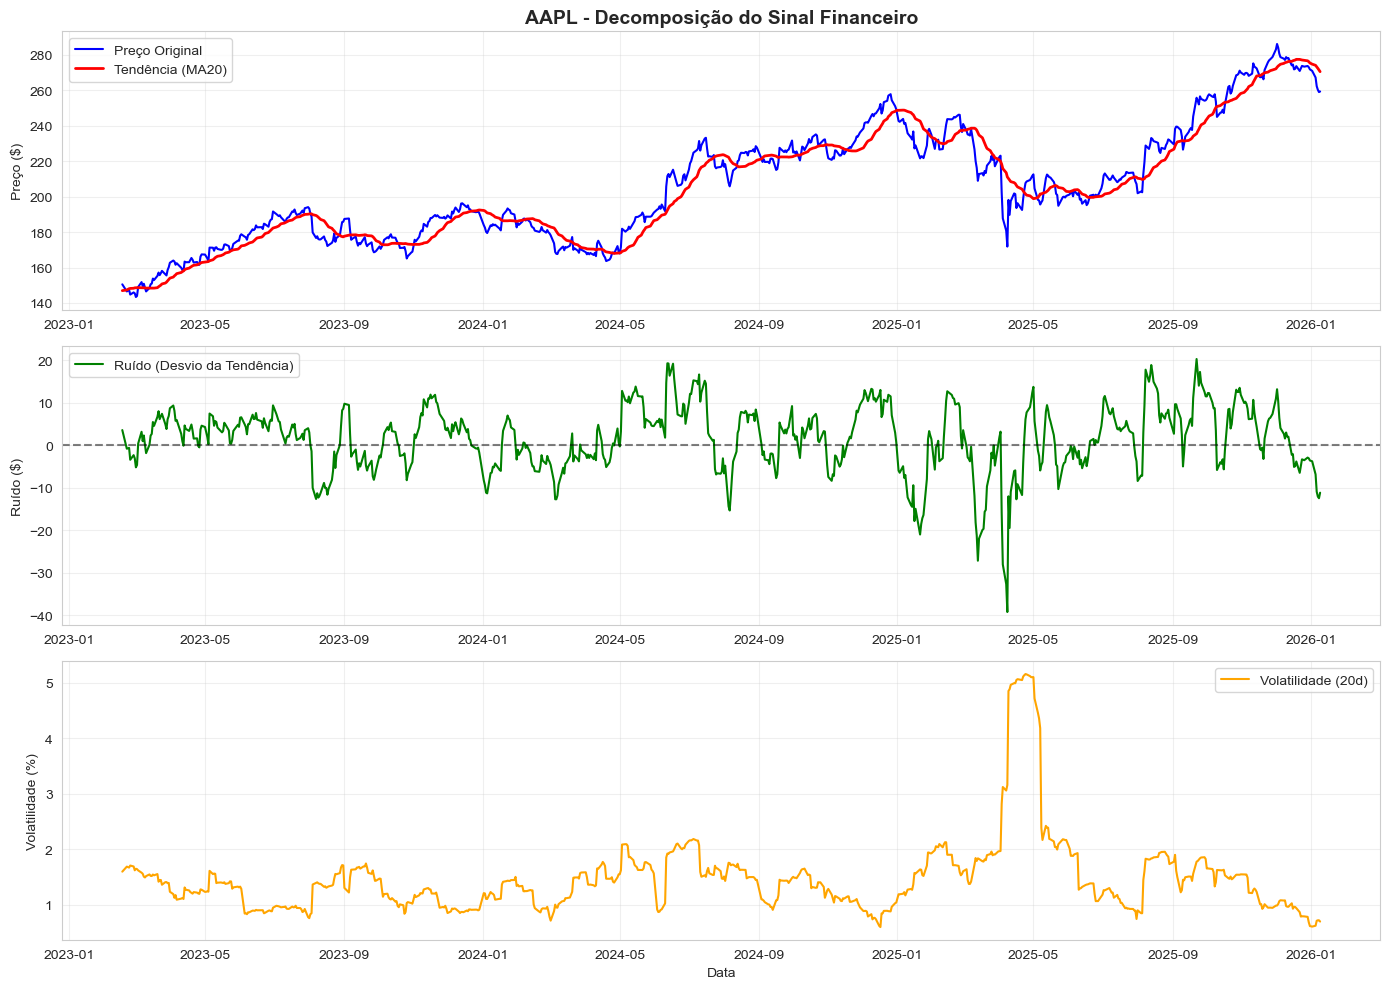

In [6]:
# Visualização da 1º Ação - AAPL (Apple)
fig, axes = plt.subplots(3, 1, figsize=(14, 10))
sample = df_raw[df_raw['ticker'] == 'AAPL'].iloc[-726:] # Utlimos 726 dias

axes[0].plot(sample['Date'], sample['Close'], label='Preço Original', color='blue')
axes[0].plot(sample['Date'], sample['Trend'], label='Tendência (MA20)', color='red', linewidth=2)
axes[0].set_title('AAPL - Decomposição do Sinal Financeiro', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Preço ($)')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(sample['Date'], sample['Noise'], label='Ruído (Desvio da Tendência)', color='green')
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_ylabel('Ruído ($)')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(sample['Date'], sample['Volatility']*100, label='Volatilidade (20d)', color='orange')
axes[2].set_ylabel('Volatilidade (%)')
axes[2].set_xlabel('Data')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Feature Engeneering

In [7]:
def create_technical_indicators(df):
    """
    Cria indicadores técnicos que capturam tendência, momentum e volatilidade
    """
    df = df.copy()
    
    # Retornos
    df['Return_1d'] = df.groupby('ticker')['Close'].pct_change(1)
    df['Return_5d'] = df.groupby('ticker')['Close'].pct_change(5)
    df['Return_10d'] = df.groupby('ticker')['Close'].pct_change(10)
    
    # Médias Móveis - Tendência de curto, médio e longo prazo
    df['SMA_5'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(5).mean())
    df['SMA_10'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(10).mean())
    df['SMA_20'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(20).mean())
    df['SMA_50'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(50).mean())
    
    # Cruzamento de médias - sinal de mudança de tendência
    df['SMA_Cross_5_20'] = (df['SMA_5'] - df['SMA_20']) / df['SMA_20']
    df['SMA_Cross_10_50'] = (df['SMA_10'] - df['SMA_50']) / df['SMA_50']
    
    # RSI - momentum
    def calculate_rsi(prices, period=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    df['RSI_14'] = df.groupby('ticker')['Close'].transform(lambda x: calculate_rsi(x, 14))
    
    # Volatilidade e Extremos
    df['BB_Middle'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(20).mean())
    df['BB_Std'] = df.groupby('ticker')['Close'].transform(lambda x: x.rolling(20).std())
    df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * 2)
    df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * 2)
    df['BB_Position'] = (df['Close'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower'])
    
    # MACD
    df['EMA_12'] = df.groupby('ticker')['Close'].transform(lambda x: x.ewm(span=12).mean())
    df['EMA_26'] = df.groupby('ticker')['Close'].transform(lambda x: x.ewm(span=26).mean())
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['MACD_Signal'] = df.groupby('ticker')['MACD'].transform(lambda x: x.ewm(span=9).mean())
    df['MACD_Diff'] = df['MACD'] - df['MACD_Signal']
    
    # Interesse do mercado
    df['Volume_MA'] = df.groupby('ticker')['Volume'].transform(lambda x: x.rolling(20).mean())
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']
    
    # Volatilidade realizada
    df['Volatility_5d'] = df.groupby('ticker')['Return_1d'].transform(lambda x: x.rolling(5).std())
    df['Volatility_20d'] = df.groupby('ticker')['Return_1d'].transform(lambda x: x.rolling(20).std())
    
    # Range diário (High - Low)
    df['Daily_Range'] = (df['High'] - df['Low']) / df['Close']
    df['Daily_Range_MA'] = df.groupby('ticker')['Daily_Range'].transform(lambda x: x.rolling(10).mean())
    
    return df

df_features = create_technical_indicators(df_raw)

print(f"Features criadas: {df_features.shape[1]} colunas")

Features criadas: 36 colunas


### Criação de Targets

In [8]:
# TARGET 1: Direção Binária (Sobe/Desce)
df_features['Future_Return'] = df_features.groupby('ticker')['Close'].pct_change().shift(-1)
df_features['Target_Binary'] = (df_features['Future_Return'] > 0).astype(int)

# TARGET 2: Direção Multiclasse (Alta/Neutra/Baixa)
threshold = 0.005  # 0.5%
df_features['Target_Multiclass'] = pd.cut(
    df_features['Future_Return'],
    bins=[-np.inf, -threshold, threshold, np.inf],
    labels=[0, 1, 2]  # 0=Baixa, 1=Neutro, 2=Alta
).astype(float)

# TARGET 3: Volatilidade (Dia volátil ou estável)
vol_threshold = df_features['Future_Return'].abs().quantile(0.7)
df_features['Target_Volatility'] = (df_features['Future_Return'].abs() > vol_threshold).astype(int)

# TARGET 4: Faixa de Preço (Regressão por intervalos)
df_features['Future_Price'] = df_features.groupby('ticker')['Close'].shift(-1)
df_features['Price_Change_Pct'] = ((df_features['Future_Price'] - df_features['Close']) / df_features['Close']) * 100

# Criar bins de faixas de preço
df_features['Target_PriceRange'] = pd.cut(
    df_features['Price_Change_Pct'],
    bins=[-np.inf, -2, -1, 0, 1, 2, np.inf],
    labels=['<-2%', '-2 a -1%', '-1 a 0%', '0 a 1%', '1 a 2%', '>2%']
)

print("Targets criados:")
print(f"  - Target_Binary (Sobe/Desce): {df_features['Target_Binary'].value_counts().to_dict()}")
print(f"  - Target_Multiclass (Alta/Neutro/Baixa): {df_features['Target_Multiclass'].value_counts().to_dict()}")
print(f"  - Target_Volatility (Volátil/Estável): {df_features['Target_Volatility'].value_counts().to_dict()}")

Targets criados:
  - Target_Binary (Sobe/Desce): {1: 5253, 0: 4787}
  - Target_Multiclass (Alta/Neutro/Baixa): {2.0: 4067, 0.0: 3645, 1.0: 2320}
  - Target_Volatility (Volátil/Estável): {0: 7030, 1: 3010}


### Preparação dos Dados

In [9]:
df_clean = df_features.dropna()

# Selecionar features para o modelo
feature_cols = [
    'Return_1d', 'Return_5d', 'Return_10d',
    'SMA_Cross_5_20', 'SMA_Cross_10_50',
    'RSI_14', 'BB_Position', 'MACD_Diff',
    'Volume_Ratio', 'Volatility_5d', 'Volatility_20d',
    'Daily_Range', 'Daily_Range_MA',
    'Trend', 'Noise', 'Volatility'  # Componentes de decomposição
]

X = df_clean[feature_cols]
y_binary = df_clean['Target_Binary']
y_multi = df_clean['Target_Multiclass']
y_vol = df_clean['Target_Volatility']

print(f"Dataset limpo: {len(X)} amostras")
print(f"   - Features: {len(feature_cols)}")
print(f"   - Período final: {df_clean['Date'].min().date()} até {df_clean['Date'].max().date()}")

Dataset limpo: 9640 amostras
   - Features: 16
   - Período final: 2021-03-24 até 2026-01-08


### Divisão Temporal dos Dados

Aplicamos parte teórica de séries temporaias


In [10]:
df_clean = df_clean.sort_values('Date')

# Split temporal: 80% treino, 20% teste
split_date = df_clean['Date'].quantile(0.8)
train_mask = df_clean['Date'] <= split_date
test_mask = df_clean['Date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train_binary = y_binary[train_mask]
y_test_binary = y_binary[test_mask]
y_train_multi = y_multi[train_mask]
y_test_multi = y_multi[test_mask]
y_train_vol = y_vol[train_mask]
y_test_vol = y_vol[test_mask]

print(f"Treino: {len(X_train)} amostras ({df_clean[train_mask]['Date'].min().date()} até {df_clean[train_mask]['Date'].max().date()})")
print(f"Teste: {len(X_test)} amostras ({df_clean[test_mask]['Date'].min().date()} até {df_clean[test_mask]['Date'].max().date()})")

Treino: 7712 amostras (2021-03-24 até 2025-01-23)
Teste: 1928 amostras (2025-01-24 até 2026-01-08)


### Normalização 

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Treino do Modelo

In [13]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=5, random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)
}

# Dicionário para armazenar resultados
results = {
    'Binary': {},
    'Multiclass': {},
    'Volatility': {}
}

In [14]:
print("\nTARGET 1: Classificação Binária (Sobe/Desce)")
print("-"*80)

for name, model in models.items():
    print(f"\nTreinando {name}...", end=" ")
    model.fit(X_train_scaled, y_train_binary)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_binary, y_pred)
    bal_acc = balanced_accuracy_score(y_test_binary, y_pred)
    f1 = f1_score(y_test_binary, y_pred)
    auc = roc_auc_score(y_test_binary, y_pred_proba)
    
    results['Binary'][name] = {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'auc_roc': auc,
        'model': model
    }
    
    print(f"= * 80")
    print(f"  Acurácia: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")

# TARGET 2
print("\TARGET 2: Classificação Multiclasse (Alta/Neutro/Baixa)")
print("-"*80)

for name, model in models.items():
    print(f"\nTreinando {name}...", end=" ")
    model_multi = type(model)(**model.get_params())  # Clone
    model_multi.fit(X_train_scaled, y_train_multi)
    y_pred = model_multi.predict(X_test_scaled)
    
    acc = accuracy_score(y_test_multi, y_pred)
    bal_acc = balanced_accuracy_score(y_test_multi, y_pred)
    f1 = f1_score(y_test_multi, y_pred, average='weighted')
    
    results['Multiclass'][name] = {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'model': model_multi
    }
    
    print(f"  Acurácia: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f}")

# TARGET 3: PREVISÃO DE VOLATILIDADE
print("="*80)
print("\TARGET 3: Previsão de Volatilidade (Volátil/Estável)")
print("="*80)

for name, model in models.items():
    print(f"\nTreinando {name}...", end=" ")
    model_vol = type(model)(**model.get_params())  # Clone
    model_vol.fit(X_train_scaled, y_train_vol)
    y_pred = model_vol.predict(X_test_scaled)
    y_pred_proba = model_vol.predict_proba(X_test_scaled)[:, 1]
    
    acc = accuracy_score(y_test_vol, y_pred)
    bal_acc = balanced_accuracy_score(y_test_vol, y_pred)
    f1 = f1_score(y_test_vol, y_pred)
    auc = roc_auc_score(y_test_vol, y_pred_proba)
    
    results['Volatility'][name] = {
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'auc_roc': auc,
        'model': model_vol
    }

    print(f"  Acurácia: {acc:.4f} | Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")


TARGET 1: Classificação Binária (Sobe/Desce)
--------------------------------------------------------------------------------

Treinando Logistic Regression... = * 80
  Acurácia: 0.5099 | Balanced Acc: 0.4954 | F1: 0.6212 | AUC: 0.4985

Treinando Random Forest... = * 80
  Acurácia: 0.5363 | Balanced Acc: 0.5243 | F1: 0.6290 | AUC: 0.5319

Treinando Gradient Boosting... = * 80
  Acurácia: 0.5301 | Balanced Acc: 0.5184 | F1: 0.6222 | AUC: 0.5241

Treinando XGBoost... = * 80
  Acurácia: 0.5301 | Balanced Acc: 0.5265 | F1: 0.5710 | AUC: 0.5269

Treinando LightGBM... = * 80
  Acurácia: 0.5223 | Balanced Acc: 0.5179 | F1: 0.5698 | AUC: 0.5144
\TARGET 2: Classificação Multiclasse (Alta/Neutro/Baixa)
--------------------------------------------------------------------------------

Treinando Logistic Regression...   Acurácia: 0.3916 | Balanced Acc: 0.3580 | F1: 0.3412

Treinando Random Forest...   Acurácia: 0.3963 | Balanced Acc: 0.3575 | F1: 0.3489

Treinando Gradient Boosting...   Acurácia: 

#### Analise de Resultados

In [17]:
comparison_data = []
for task in ['Binary', 'Multiclass', 'Volatility']:
    for model_name, metrics in results[task].items():
        comparison_data.append({
            'Tarefa': task,
            'Modelo': model_name,
            'Acurácia': metrics['accuracy'],
            'Balanced Acc': metrics['balanced_accuracy'],
            'F1-Score': metrics['f1_score'],
            'AUC-ROC': metrics.get('auc_roc', np.nan)
        })

df_results = pd.DataFrame(comparison_data)

#### Visualização dos resultados


Tabela Comparativa de Métricas:
    Tarefa              Modelo  Acurácia  Balanced Acc  F1-Score  AUC-ROC
    Binary Logistic Regression  0.509855      0.495433  0.621242 0.498476
    Binary       Random Forest  0.536307      0.524347  0.629046 0.531926
    Binary   Gradient Boosting  0.530083      0.518442  0.622185 0.524063
    Binary             XGBoost  0.530083      0.526467  0.571023 0.526940
    Binary            LightGBM  0.522303      0.517850  0.569827 0.514449
Multiclass Logistic Regression  0.391598      0.357998  0.341176      NaN
Multiclass       Random Forest  0.396266      0.357550  0.348908      NaN
Multiclass   Gradient Boosting  0.395228      0.357801  0.349953      NaN
Multiclass             XGBoost  0.401452      0.376083  0.384703      NaN
Multiclass            LightGBM  0.387448      0.357059  0.360539      NaN
Volatility Logistic Regression  0.749481      0.584491  0.324476 0.715177
Volatility       Random Forest  0.746369      0.594735  0.359109 0.703067
Volat

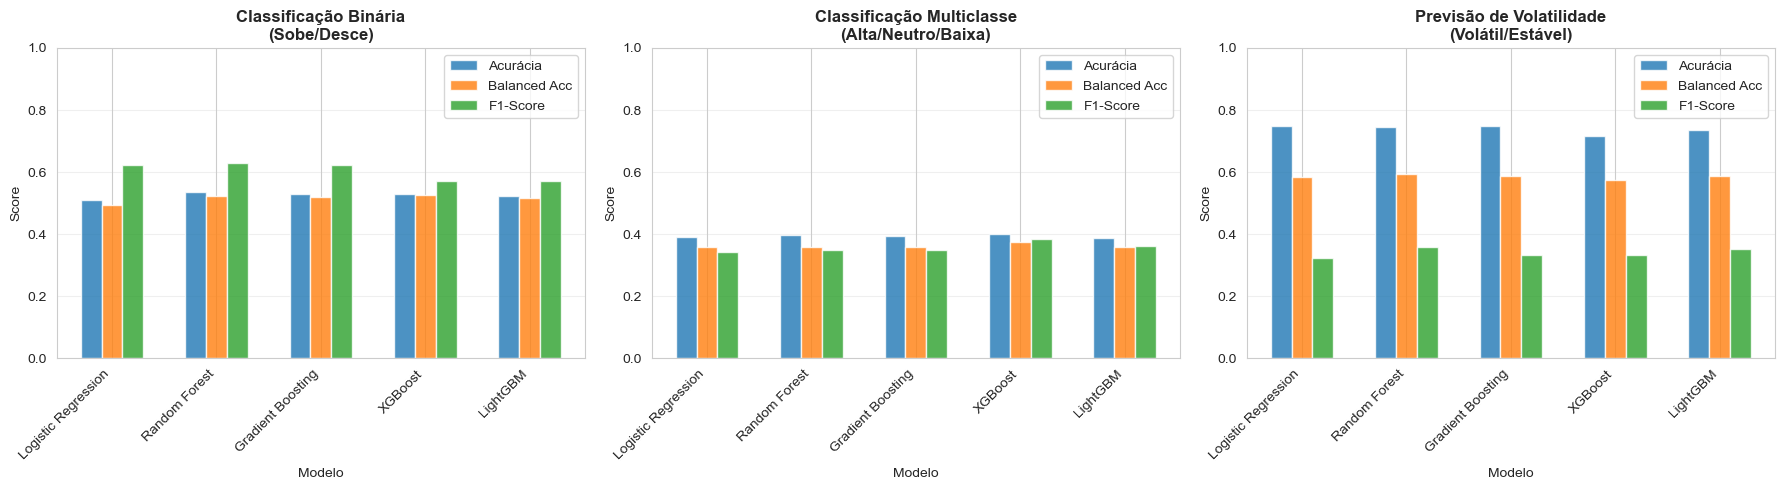

In [18]:
print("\nTabela Comparativa de Métricas:")
print(df_results.to_string(index=False))

# Visualização dos resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

tasks = ['Binary', 'Multiclass', 'Volatility']
titles = ['Classificação Binária\n(Sobe/Desce)', 
          'Classificação Multiclasse\n(Alta/Neutro/Baixa)', 
          'Previsão de Volatilidade\n(Volátil/Estável)']

for idx, (task, title) in enumerate(zip(tasks, titles)):
    data = df_results[df_results['Tarefa'] == task]
    
    x = np.arange(len(data))
    width = 0.2
    
    axes[idx].bar(x - width, data['Acurácia'], width, label='Acurácia', alpha=0.8)
    axes[idx].bar(x, data['Balanced Acc'], width, label='Balanced Acc', alpha=0.8)
    axes[idx].bar(x + width, data['F1-Score'], width, label='F1-Score', alpha=0.8)
    
    axes[idx].set_xlabel('Modelo')
    axes[idx].set_ylabel('Score')
    axes[idx].set_title(title, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(data['Modelo'], rotation=45, ha='right')
    axes[idx].legend()
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].set_ylim(0, 1)

plt.tight_layout()
plt.show()

Os resultados obtidos demonstram que a previsão da direção diária dos preços apresenta desempenho apenas marginalmente superior ao acaso, com AUC-ROC em torno de 0.53, confirmando a elevada dominância do ruído em séries financeiras de curto prazo. Em contraste, a tarefa de previsão de volatilidade revelou desempenho significativamente superior, com valores de AUC próximos de 0.70, sugerindo que, embora os retornos sejam amplamente imprevisíveis, os regimes de mercado exibem padrões temporais exploráveis. Estes resultados corroboram a hipótese central do trabalho de que técnicas de Machine Learning são mais eficazes na identificação de estruturas estatísticas agregadas do que na previsão determinística de movimentos de preços.”

### ANÁLISE DETALHADA DO MELHOR MODELO

ANÁLISE DETALHADA DO MELHOR MODELO

 Melhor modelo: XGBoost
   Balanced Accuracy: 0.5265


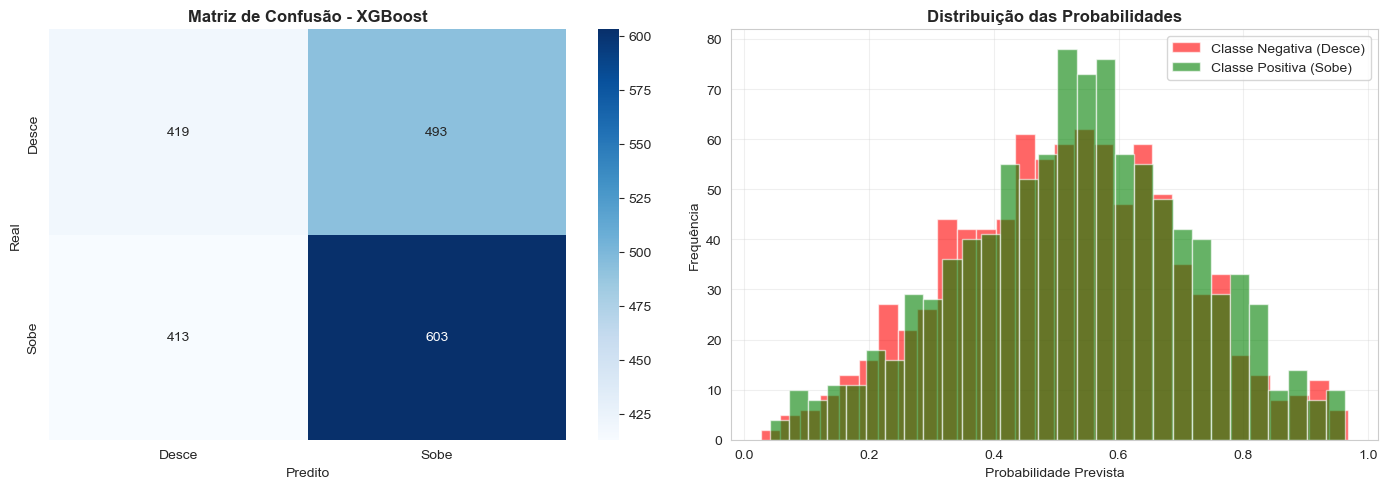

In [22]:
print("ANÁLISE DETALHADA DO MELHOR MODELO")

# Selecionar melhor modelo para classificação binária
best_model_name = max(results['Binary'], key=lambda x: results['Binary'][x]['balanced_accuracy'])
best_model = results['Binary'][best_model_name]['model']

print(f"\n Melhor modelo: {best_model_name}")
print(f"   Balanced Accuracy: {results['Binary'][best_model_name]['balanced_accuracy']:.4f}")

# Predições
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Matriz de confusão
cm = confusion_matrix(y_test_binary, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Matriz de Confusão - {best_model_name}', fontweight='bold')
axes[0].set_ylabel('Real')
axes[0].set_xlabel('Predito')
axes[0].set_xticklabels(['Desce', 'Sobe'])
axes[0].set_yticklabels(['Desce', 'Sobe'])

# Distribuição de probabilidades
axes[1].hist(y_pred_proba[y_test_binary == 0], bins=30, alpha=0.6, label='Classe Negativa (Desce)', color='red')
axes[1].hist(y_pred_proba[y_test_binary == 1], bins=30, alpha=0.6, label='Classe Positiva (Sobe)', color='green')
axes[1].set_xlabel('Probabilidade Prevista')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição das Probabilidades', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### Overview da Classificação


Relatório de Classificação:
              precision    recall  f1-score   support

       Desce       0.50      0.46      0.48       912
        Sobe       0.55      0.59      0.57      1016

    accuracy                           0.53      1928
   macro avg       0.53      0.53      0.53      1928
weighted avg       0.53      0.53      0.53      1928


Top 10 Features Mais Importantes:
       Feature  Importance
SMA_Cross_5_20    0.070121
         Noise    0.069587
     Return_5d    0.068840
  Volume_Ratio    0.067954
   Daily_Range    0.067669
Volatility_20d    0.067643
 Volatility_5d    0.067022
     MACD_Diff    0.067022
   BB_Position    0.066675
Daily_Range_MA    0.065644


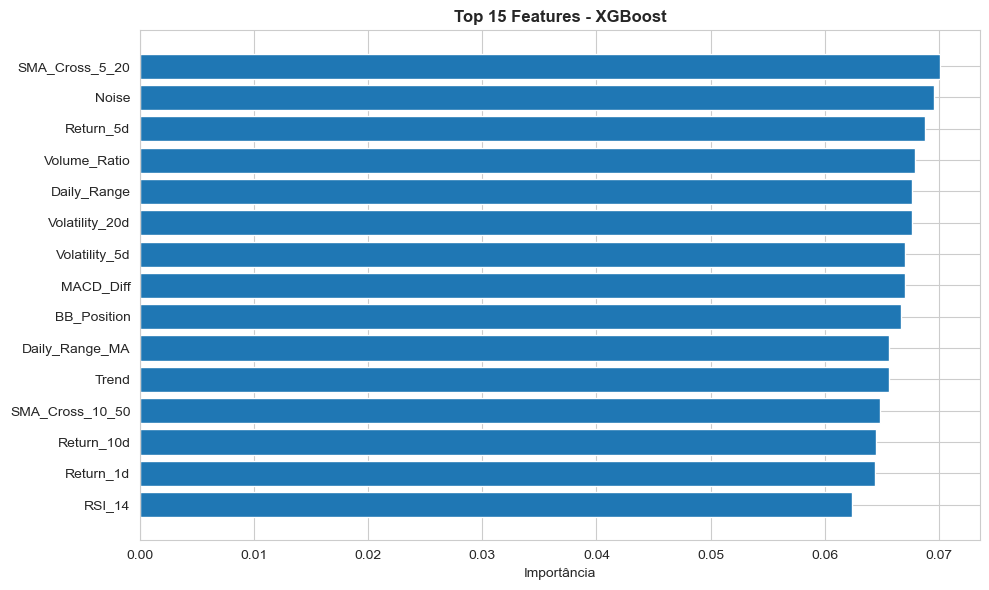

In [29]:
print("\nRelatório de Classificação:")
print(classification_report(y_test_binary, y_pred, target_names=['Desce', 'Sobe']))

# Feature importance (se disponível)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 10 Features Mais Importantes:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Visualizar
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'].head(15), feature_importance['Importance'].head(15))
    plt.xlabel('Importância')
    plt.title(f'Top 15 Features - {best_model_name}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### INFERÊNCIA EM DADOS ATUAIS DO MERCADO

In [30]:
latest_data = df_clean.groupby('ticker').tail(1)
X_latest = latest_data[feature_cols]
X_latest_scaled = scaler.transform(X_latest)

# Predições
pred_binary = best_model.predict(X_latest_scaled)
pred_proba = best_model.predict_proba(X_latest_scaled)[:, 1]

# Criar DataFrame de resultados
inference_results = pd.DataFrame({
    'Ticker': latest_data['ticker'].values,
    'Data': latest_data['Date'].values,
    'Preço Atual': latest_data['Close'].values,
    'Previsão': ['SOBE ↑' if p == 1 else 'DESCE ↓' for p in pred_binary],
    'Confiança (%)': pred_proba * 100,
    'Sinal': ['FORTE' if (p > 0.6 or p < 0.4) else 'FRACO' for p in pred_proba]
})

print("Previsões para o Próximo Dia:")
print("\n")
print(inference_results.to_string(index=False))

# Tendência agregada do mercado
market_sentiment = pred_binary.mean()
print(f"\nTENDÊNCIA AGREGADA DO MERCADO:")
if market_sentiment > 0.6:
    print(f"    ALTA ({market_sentiment*100:.1f}% das ações com tendência de subida)")
elif market_sentiment < 0.4:
    print(f"    BAIXA ({(1-market_sentiment)*100:.1f}% das ações com tendência de queda)")
else:
    print(f"    NEUTRA ({market_sentiment*100:.1f}% de equilíbrio)")

Previsões para o Próximo Dia:


Ticker       Data  Preço Atual Previsão  Confiança (%) Sinal
  AMZN 2026-01-08   246.289993   SOBE ↑      67.315910 FORTE
  NVDA 2026-01-08   185.039993  DESCE ↓      46.642132 FRACO
  META 2026-01-08   646.059998  DESCE ↓      40.349518 FRACO
 GOOGL 2026-01-08   325.440002   SOBE ↑      61.090176 FORTE
  MSFT 2026-01-08   478.109985  DESCE ↓      34.308117 FORTE
  AAPL 2026-01-08   259.040009   SOBE ↑      72.816483 FORTE
  TSLA 2026-01-08   435.799988  DESCE ↓      43.273289 FRACO
  NFLX 2026-01-08    90.529999   SOBE ↑      84.497307 FORTE

TENDÊNCIA AGREGADA DO MERCADO:
    NEUTRA (50.0% de equilíbrio)


Apesar de a maioria das ações analisadas apresentar probabilidade ligeiramente superior a 50% de movimento positivo, todas as previsões individuais exibem baixa confiança. Assim, a tendência agregada deve ser interpretada como um viés marginal de subida, e não como uma indicação robusta de tendência de mercado

**Comentário sobre os resultados**

> Os resultados obtidos evidenciam a elevada dificuldade inerente à previsão direcional de curto prazo, sendo o desempenho marginalmente superior ao acaso consistente com mercados altamente eficientes.

### Exportação do Modelo

In [39]:
import joblib
from datetime import datetime
import os
import json
model_dir = 'models'
os.makedirs(model_dir, exist_ok=True)


best_model_name = max(results['Binary'], key=lambda x: results['Binary'][x]['balanced_accuracy'])
best_model = results['Binary'][best_model_name]['model']
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

In [41]:
print("="*80)
print("EXPORTAÇÃO DO MODELO")
print("="*80)

# 1. Salvar o melhor modelo (Random Forest)
model_filename = f'{model_dir}/rf_binary_classifier_{timestamp}.pkl'
joblib.dump(best_model, model_filename)
print(f"\n✓ Modelo salvo: {model_filename}")

# 2. Salvar o scaler (essencial para normalização)
scaler_filename = f'{model_dir}/scaler_{timestamp}.pkl'
joblib.dump(scaler, scaler_filename)
print(f"✓ Scaler salvo: {scaler_filename}")

# 3. Salvar configuração e metadados
model_metadata = {
    'model_type': best_model_name,
    'model_class': str(type(best_model).__name__),
    'features': feature_cols,
    'n_features': len(feature_cols),
    'target': 'Target_Binary',
    'target_description': 'Classificação binária: 1=Sobe, 0=Desce',
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'metrics': {
        'accuracy': float(results['Binary'][best_model_name]['accuracy']),
        'balanced_accuracy': float(results['Binary'][best_model_name]['balanced_accuracy']),
        'f1_score': float(results['Binary'][best_model_name]['f1_score']),
        'auc_roc': float(results['Binary'][best_model_name]['auc_roc'])
    },
    'training_period': {
        'start': str(df_clean[train_mask]['Date'].min().date()),
        'end': str(df_clean[train_mask]['Date'].max().date())
    },
    'test_period': {
        'start': str(df_clean[test_mask]['Date'].min().date()),
        'end': str(df_clean[test_mask]['Date'].max().date())
    },
    'stocks': tech_list,
    'data_split': '80% treino / 20% teste (temporal)',
    'timestamp': timestamp,
    'export_date': str(datetime.now())
}

metadata_filename = f'{model_dir}/model_metadata_{timestamp}.json'
with open(metadata_filename, 'w', encoding='utf-8') as f:
    json.dump(model_metadata, f, indent=4, ensure_ascii=False)
print(f"✓ Metadados salvos: {metadata_filename}")


EXPORTAÇÃO DO MODELO

✓ Modelo salvo: models/rf_binary_classifier_20260111_004550.pkl
✓ Scaler salvo: models/scaler_20260111_004550.pkl
✓ Metadados salvos: models/model_metadata_20260111_004550.json


#### Criar arquivo de instruções de uso

In [43]:
instructions = f"""
# Instruções de Uso do Modelo

## Arquivos gerados:
1. {model_filename} - Modelo Random Forest treinado
2. {scaler_filename} - Scaler para normalização
3. {metadata_filename} - Metadados e configuração

## Como carregar o modelo:
```python
import joblib
import pandas as pd

# Carregar modelo e scaler
model = joblib.load('{model_filename}')
scaler = joblib.load('{scaler_filename}')

# Features necessárias (na ordem correta):
features = {feature_cols}

# Fazer previsão com novos dados:
# 1. Preparar DataFrame com as features
# X_new = pd.DataFrame(...)  # seus novos dados

# 2. Normalizar
# X_new_scaled = scaler.transform(X_new[features])

# 3. Prever
# predictions = model.predict(X_new_scaled)
# probabilities = model.predict_proba(X_new_scaled)[:, 1]
```

## Métricas do Modelo:
- Balanced Accuracy: {results['Binary'][best_model_name]['balanced_accuracy']:.4f}
- F1-Score: {results['Binary'][best_model_name]['f1_score']:.4f}
- AUC-ROC: {results['Binary'][best_model_name]['auc_roc']:.4f}

## Período de Treino: {df_clean[train_mask]['Date'].min().date()} a {df_clean[train_mask]['Date'].max().date()}
## Período de Teste: {df_clean[test_mask]['Date'].min().date()} a {df_clean[test_mask]['Date'].max().date()}
"""

instructions_filename = f'{model_dir}/INSTRUCTIONS_{timestamp}.txt'
with open(instructions_filename, 'w', encoding='utf-8') as f:
    f.write(instructions)
print(f"Instruções salvas: {instructions_filename}")

print(f"\n{'='*80}")
print("EXPORTAÇÃO CONCLUÍDA COM SUCESSO!")
print(f"{'='*80}")
print(f"\nTodos os arquivos foram salvos no diretório: {model_dir}/")
print(f"\nPara usar o modelo posteriormente:")
print(f"  model = joblib.load('{model_filename}')")
print(f"  scaler = joblib.load('{scaler_filename}')")

✓ Instruções salvas: models/INSTRUCTIONS_20260111_004550.txt

EXPORTAÇÃO CONCLUÍDA COM SUCESSO!

Todos os arquivos foram salvos no diretório: models/

Para usar o modelo posteriormente:
  model = joblib.load('models/rf_binary_classifier_20260111_004550.pkl')
  scaler = joblib.load('models/scaler_20260111_004550.pkl')


#### Uso do Modelo

In [90]:
MODEL_PATH = "models/rf_binary_classifier_20260111_004550.pkl"  # substituir pelo teu XGBoost
SCALER_PATH = "models/scaler_20260111_004550.pkl"
METADATA_PATH = "models/model_metadata_20260111_004550.json"

In [92]:
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)

with open(METADATA_PATH, "r") as f:
    metadata = json.load(f)

features = metadata["features"]  # lista completa das 16 features

In [94]:
# Criar DataFrame de novos dados
X_new = pd.DataFrame([{feat: 0 for feat in features}])

# Valores Exemplo
X_new.loc[0, "Return_1d"] = 0.012
X_new.loc[0, "Return_5d"] = 0.045
X_new.loc[0, "Return_10d"] = 0.078
X_new.loc[0, "SMA_Cross_5_20"] = 1
X_new.loc[0, "SMA_Cross_10_50"] = 0
X_new.loc[0, "RSI_14"] = 58.3
X_new.loc[0, "BB_Position"] = 0.62
X_new.loc[0, "MACD_Diff"] = 0.13
X_new.loc[0, "Volume_Ratio"] = 1.2
X_new.loc[0, "Volatility_5d"] = 0.012
X_new.loc[0, "Volatility_20d"] = 0.015
X_new.loc[0, "Daily_Range"] = 3.2
X_new.loc[0, "Daily_Range_MA"] = 2.1
X_new.loc[0, "Trend"] = 1
X_new.loc[0, "Noise"] = 0.003
X_new.loc[0, "Volatility"] = 0.012

In [96]:
X_scaled = scaler.transform(X_new[features])

pred = model.predict(X_scaled)[0]
prob = model.predict_proba(X_scaled)[0, 1]  # probabilidade da classe 1 (subida)

print("Predição (0=Desce, 1=Sobe):", pred)
print(f"Probabilidade de subida: {prob:.2%}")

Predição (0=Desce, 1=Sobe): 1
Probabilidade de subida: 89.38%
